In [167]:
import os, glob, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [168]:
# add your own file path here 
aria_FILE_PATH = '/Users/ernyk/OneDrive - National University of Singapore/nus/bt4241/bt4241 proj ideas/BT4241-2510-Project/did-by-country/ARIA Year End Charts' 
billboard_FILE_PATH = '/Users/ernyk/OneDrive - National University of Singapore/nus/bt4241/bt4241 proj ideas/BT4241-2510-Project/did-by-country/Billboard Year End Charts'

# audio features to consider
columns_to_read = ['BPM', 'Dance', 'Energy', 'Happy']
covariates = ["GDP_growth", "unemployment_change", "inflation"]

# create panel dataframe
chart_panel_df = pd.DataFrame(columns=['Country', 'Treat_Grp', 'Year', 'post_recession', 'BPM', 'Dance', 'Energy', 'Happy'])

### data merging
macroeconomic data processing

In [170]:
# set columns to read from macroeconomic data
def set_time_period(start, end):
    years = list(map(str, list(range(start, end))))
    li = ["Country Code"]
    li.extend(years)
    return years, li

years, li = set_time_period(2003, 2014)

# read macroeconomic data
def read_data(csv_name, col_list, first_col):
    stats_df = pd.read_csv(csv_name, usecols=col_list)

    # filter for australian and US data
    stats_df.loc[(stats_df['Country Code'] == 'AUS') | (stats_df['Country Code'] == 'USA')]

    #drop first column (used for calculation)
    stats_df.drop([first_col], axis=1)
    return stats_df

gdp_stats_df = read_data("gdp_growth.csv", li, "2003")
inflation_stats_df = read_data('inflation_rate.csv', li, "2003")
unemployment_stats_df = read_data('unemployment_rate.csv', li,"2003")

# calculate yearly change in unemployment rate
unemployment_change_stats_df = unemployment_stats_df.copy()
for i in years:
    if i == '2003':
        continue
    i_prev = str(int(i) - 1)
    unemployment_change_stats_df[i] = (unemployment_change_stats_df[i] - unemployment_change_stats_df[i_prev]) / unemployment_change_stats_df[i]
        

covariate_data = [gdp_stats_df, inflation_stats_df, unemployment_change_stats_df]
    

joining macroeconomic statistics data with song data 

In [171]:
# IGNORE
def add_to_panel(file_path, data, columns_to_read, country_code, covariates, covariate_data, position):
    all_files = os.listdir(file_path)
    output = data
    for filename in all_files:
        year = re.split(r'[ .]', filename)[-2]
        curr_year_csv = pd.read_csv(os.path.join(file_path, filename), usecols=columns_to_read)
        median_audio_features = curr_year_csv.mean()
        post_recession = 0 if int(year) < 2008 else 1
        row_dict = {
            'Country': [country_code], 
            'Treat_Grp': [0],
            'Year': [int(year)], 
            'post_recession': [post_recession], 
        }
        for feature in columns_to_read:
            row_dict[feature] = [median_audio_features[feature]]
        for i in range(len(covariates)):
            row_dict[covariates[i]] = (covariate_data[i]).at[position, year]
        new_row_df = pd.DataFrame(row_dict)
        output = pd.concat([chart_panel_df, new_row_df], ignore_index=True)
    return output

# building the aria statistics first
#output = add_to_panel(aria_FILE_PATH, chart_panel_df, columns_to_read, "AUS", covariates, covariate_data, 13)
all_files = os.listdir(aria_FILE_PATH)
for filename in all_files:
    year = re.split(r'[ .]', filename)[-2]
    curr_year_csv = pd.read_csv(os.path.join(aria_FILE_PATH, filename), usecols=columns_to_read)
    median_audio_features = curr_year_csv.mean()
    post_recession = 0 if int(year) < 2008 else 1
    new_row_df = pd.DataFrame({
        'Country': ['AUS'], 
        'Treat_Grp': [0],
        'Year': [int(year)], 
        'GDP_growth': gdp_stats_df.at[13, year],
        'inflation': inflation_stats_df.at[13, year],
        'unemployment_change': unemployment_change_stats_df.at[13, year],
        'post_recession': [post_recession], 
        'BPM': [median_audio_features['BPM']], 
        'Dance': [median_audio_features['Dance']], 
        'Energy': [median_audio_features['Energy']],
        'Happy': [median_audio_features['Happy']]
    })
    chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)

# building the billboard statistics now
all_files = os.listdir(billboard_FILE_PATH)
for filename in all_files:
    year = filename.split()[0]
    curr_year_csv = pd.read_csv(os.path.join(billboard_FILE_PATH, filename), usecols=columns_to_read)
    median_audio_features = curr_year_csv.mean()
    post_recession = 0 if int(year) < 2008 else 1
    new_row_df = pd.DataFrame({
        'Country': ['USA'], 
        'Treat_Grp': [1],
        'Year': [int(year)],
        'GDP_growth': gdp_stats_df.at[251, year], 
        'inflation': inflation_stats_df.at[251, year],
        'unemployment_change': unemployment_change_stats_df.at[251, year],
        'post_recession': [post_recession], 
        'BPM': [median_audio_features['BPM']], 
        'Dance': [median_audio_features['Dance']], 
        'Energy': [median_audio_features['Energy']],
        'Happy': [median_audio_features['Happy']]
    })
    chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)

C:\Users\ernyk\AppData\Local\Temp\ipykernel_7848\3387268617.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)


### checking for parallel trends assumption
plotted trends of audio features over time, visually inspected graph before recession to determine if audio features of songs followed similar trends

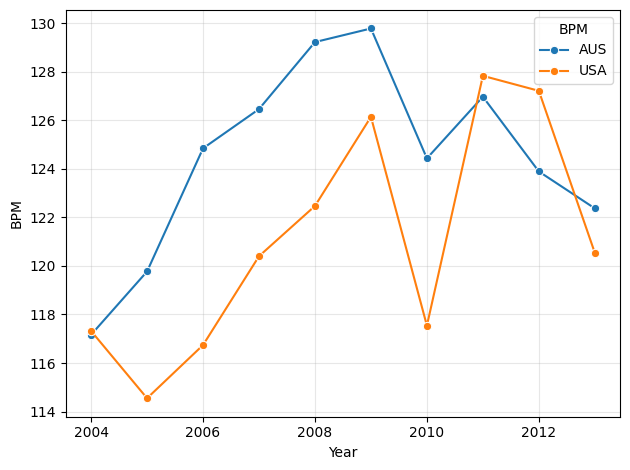

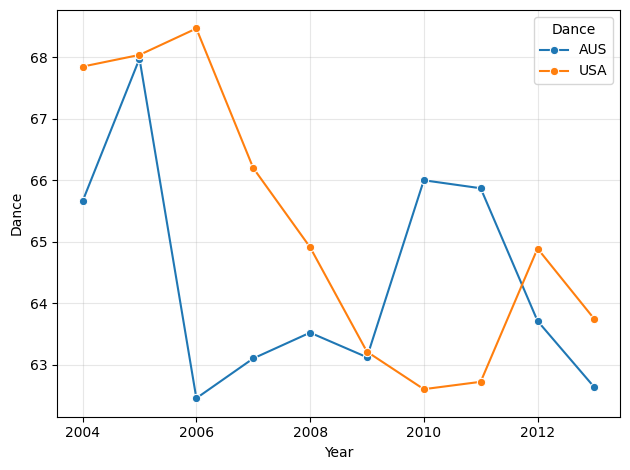

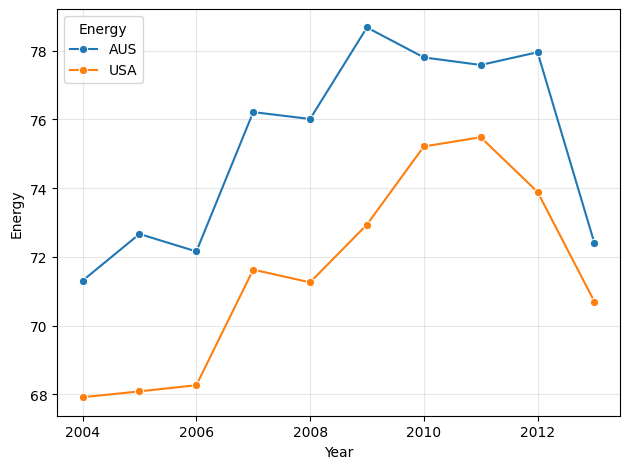

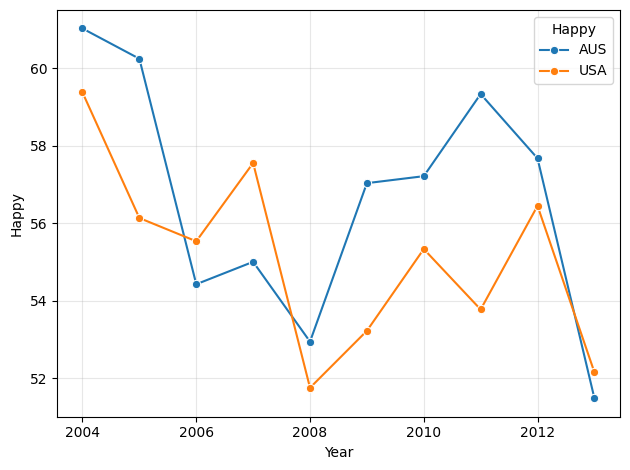

In [172]:
def plot_charts(audio_feature_list):
    for audio_feature in audio_feature_list:
        sns.lineplot(
            data=chart_panel_df,
            x='Year',
            y=audio_feature,
            hue='Country',
            marker='o'
        )

        plt.legend(title=audio_feature)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_charts(columns_to_read)

In [173]:
def run_did(audio_feature, covariates):
    # Create the interaction term for DiD
    chart_panel_df["did"] = chart_panel_df["Treat_Grp"] * chart_panel_df["post_recession"]

    # Run a fixed-effects (entity & time) DiD regression using OLS with dummy FE
    # Entity FE: C(country)
    # Time FE: C(year)
    covariate_string = '+'.join(covariates)
    print(covariate_string)
    model = smf.ols(
        formula=f"{audio_feature} ~ did + C(Country) + C(Year) + {covariate_string}",
        data=chart_panel_df
    ).fit(cov_type="HC1")  # HC1 = robust (heteroskedasticity-consistent)

    print(model.summary())

for i in columns_to_read:
    run_did(i, covariates)

GDP_growth+unemployment_change+inflation
                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     6.394
Date:                Tue, 11 Nov 2025   Prob (F-statistic):             0.0255
Time:                        18:30:26   Log-Likelihood:                -35.853
No. Observations:                  20   AIC:                             101.7
Df Residuals:                       5   BIC:                             116.6
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------